In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
path = "/Users/sreevathsadb/Masters/Project/Data/"
import plotly.express as px
pd.set_option("display.max_columns",1000)
pd.set_option('display.max_rows', 17544) 
%matplotlib inline

# Configuring plotting visual and sizes
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
path = "/Users/sreevathsadb/Masters/Project/Data/"
path = path + 'dublin_bikes/' # use your path
#file_paths = glob.glob(path + "20*")
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018','2019', '2020',
       '2021', '2022']
selected = ['2016', '2017', '2018','2019', '2020','2021']

data = []
for i in range(0,len(selected)):
    #print(path+str(pre_post_covid[i])+'.csv')
    temp_data = pd.read_csv(path+str(selected[i])+'.csv', index_col=None, header=0)
    data.append(temp_data)
data = pd.concat(data, axis=0, ignore_index=True)
data.shape

(47292318, 22)

In [3]:
#(37470767, 17)
data.drop_duplicates(keep= 'first',inplace=True)
data.shape

(47292318, 22)

In [4]:
#remove incorrect/bad samples
data = data.drop(data[(data['available_bike_stands'] == 0) & (data['available_bikes'] == 0)].index)
data = data.drop(data[(data['available_bike_stands'] + data['available_bikes']) != data['total_bike_stands']].index)
data.shape

(45150644, 22)

In [5]:
data.columns

Index(['id', 'timestamp', 'total_bike_stands', 'available_bike_stands',
       'available_bikes', 'year', 'month', 'day', 'hour', 'minute', 'weekday',
       'number', 'name', 'latitude', 'longitude', 'holiday', 'season',
       'date_for_merge', 'rain', 'temp', 'wdsp', 'wdsp_classified'],
      dtype='object')

In [6]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
#data['time'] = data['timestamp'].dt.time
data['date'] = data['timestamp'].dt.date
#data['date_for_merge'] = data['timestamp'].dt.round('H')
conditions = [
    (data['weekday'] == "Saturday"),
    (data['weekday'] == "Sunday"),
    ]
values = ["Saturday", "Sunday"]
data['day_type']  = np.select(conditions, values,default="Weekday")

conditions = [
    (data['hour'] < 6),
    (data['hour'] < 11),
    (data['hour'] < 16),
    (data['hour'] < 20),
    (data['hour'] <= 23)
    ]
values = ["Overnight ", "6AM-10AM ", "11AM-3PM ","4PM-7PM ","8PM-11PM "]
data['classified_time'] = np.select(conditions, values,default="Overnight ")
data['cluster_group'] = data['classified_time'] + data['day_type']

### Weather # Beaufort Scale

### Time Series analysis for Wind Speed

In [7]:
weather = pd.read_csv('/Users/sreevathsadb/Masters/Project/Data/hly532.csv')

weather['date'] = pd.to_datetime(weather['date'])
weather['year'] = weather['date'].dt.year
weather['date_i'] = weather['date'].dt.date
weather_df = weather[(weather['year']<2022)]

### Time Series analysis for Wind Speed

In [8]:
weather_df_ws = weather_df.groupby(['date_i'])['wdsp'].mean().reset_index(name ='wdsp_mean')
fig = px.line(weather_df_ws, x='date_i', y='wdsp_mean', title='Time Series analysis for Wind Speed')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Time Series analysis for Temperature

In [9]:
weather_df_temp = weather_df.groupby(['date_i'])['temp'].mean().reset_index(name ='temp_mean')
fig = px.line(weather_df_temp, x='date_i', y='temp_mean', title='Time Series analysis for Temperature')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Time Series analysis for Rain

In [10]:
weather_df_rain = weather_df.groupby(['date_i'])['rain'].mean().reset_index(name ='rain_mean')
fig = px.line(weather_df_rain, x='date_i', y='rain_mean', title='Time Series analysis for Rain')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [11]:
merged_data = data
merged_data = merged_data.sort_values(['id', 'timestamp'])

In [12]:
# identify bike arrivals and bike departures
merged_data['bike_arr_dep'] = merged_data.groupby('id')['available_bike_stands'].diff(-1)
merged_data['bike_arr'] = np.where(merged_data['bike_arr_dep'] > 0, merged_data['bike_arr_dep'], 0)
merged_data['bike_dep'] = np.where(merged_data['bike_arr_dep'] < 0, merged_data['bike_arr_dep'], 0)
merged_data['interactions'] = abs(merged_data['bike_arr']) + abs(merged_data['bike_dep'])

In [13]:
null_data = merged_data[merged_data.isnull().any(axis=1)]
len(null_data)

111

### Year wise monthly distribution of Bike Activity

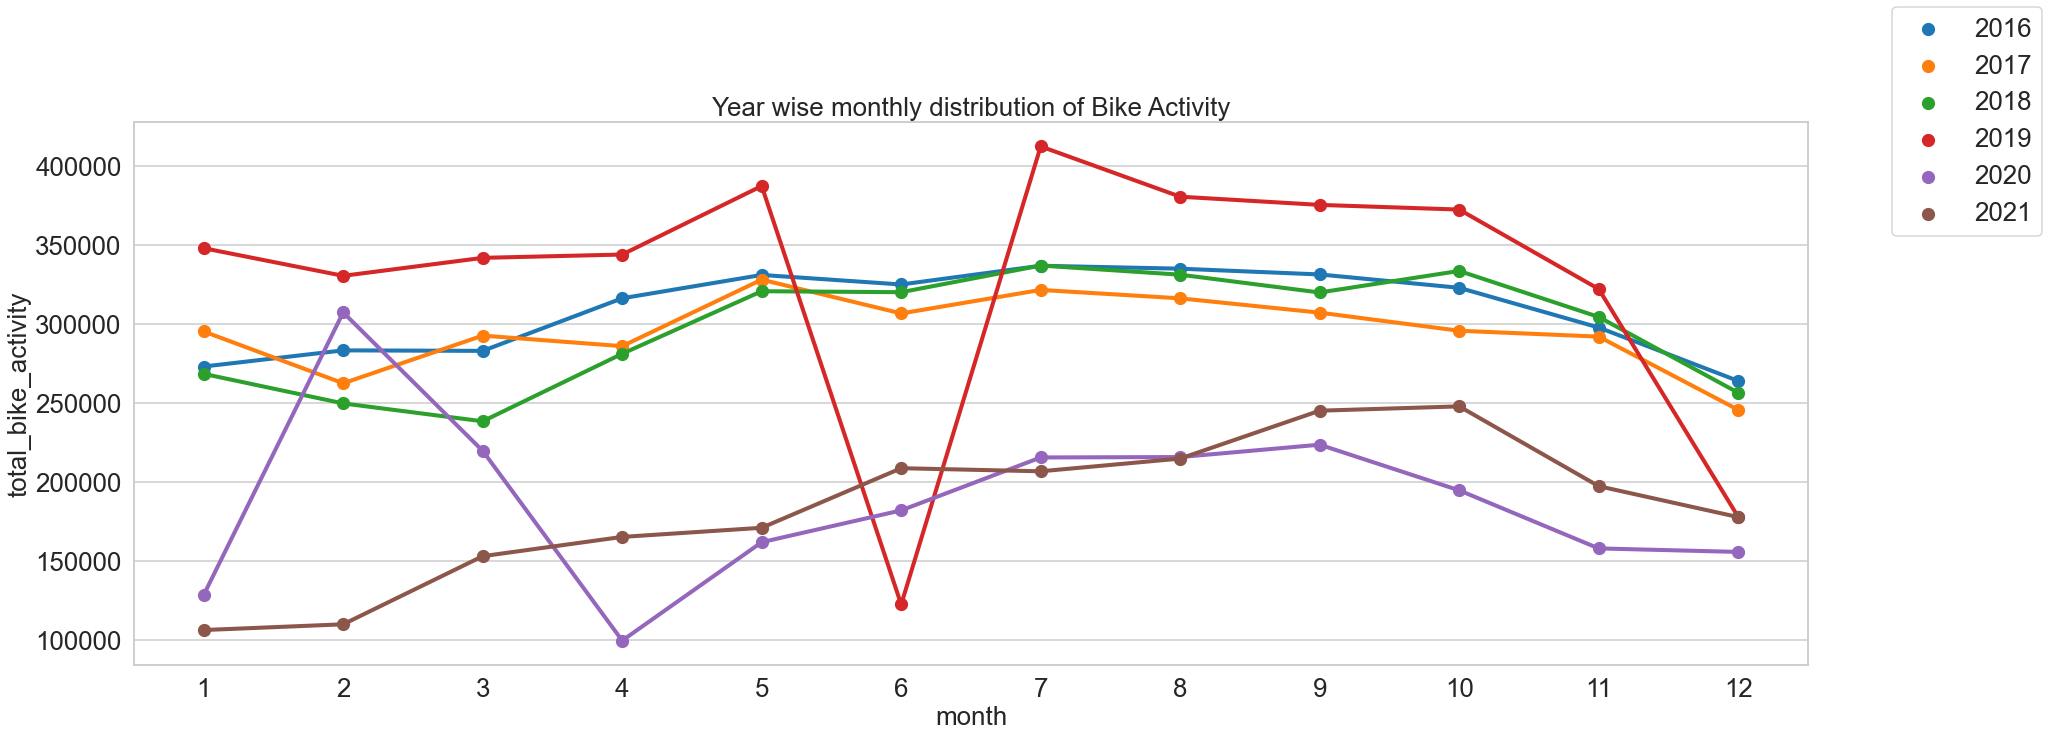

In [14]:
bike_activity_year_month = merged_data.groupby(['year','month'])['interactions'].sum().reset_index(name ='total_bike_activity')
bike_activity_year_month = bike_activity_year_month.sort_values(by='total_bike_activity',ascending=False) 
bike_activity_year_month = bike_activity_year_month.reset_index(drop=True)
bike_activity_year_month = bike_activity_year_month.sort_values(by=['year','month'])
fig,ax = plt.subplots()
sns.pointplot(data=bike_activity_year_month[['year',
                           'total_bike_activity',
                           'month']],
              x='month',
              y='total_bike_activity',
              hue='year',
              ax=ax)
ax.set(title="Year wise monthly distribution of Bike Activity")

plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Season wise hourly distribution of Bike Activity

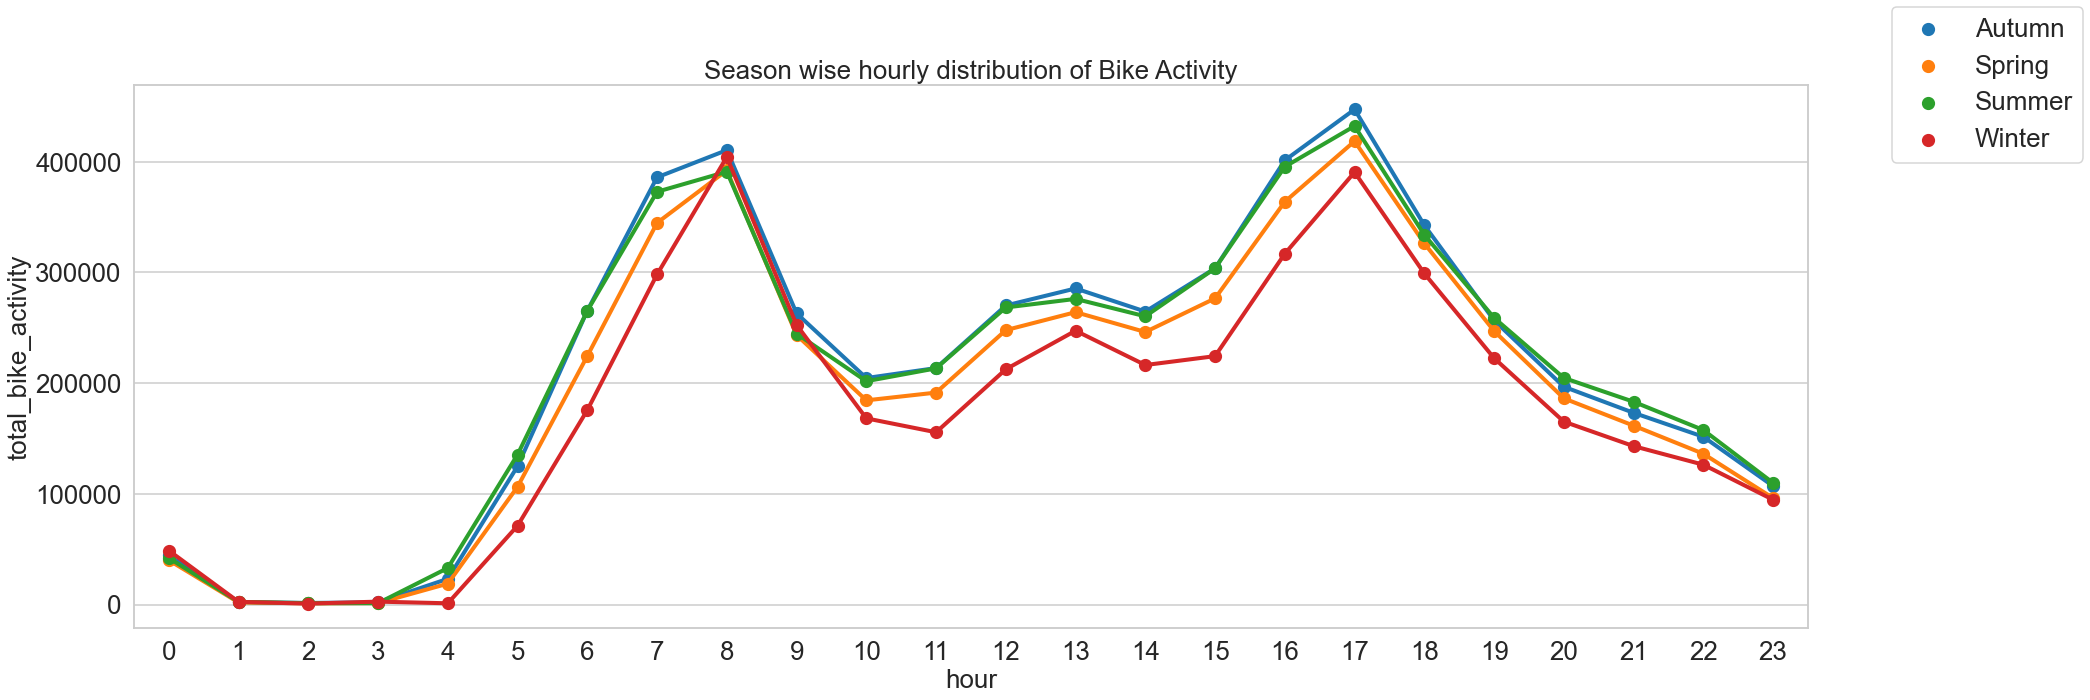

In [15]:
bike_activity_season_hour = merged_data.groupby(['season','hour'])['interactions'].sum().reset_index(name ='total_bike_activity')
bike_activity_season_hour = bike_activity_season_hour.sort_values(by='total_bike_activity',ascending=False) 
bike_activity_season_hour = bike_activity_season_hour.reset_index(drop=True)
bike_activity_season_hour = bike_activity_season_hour.sort_values(by=['season','hour'])
fig,ax = plt.subplots()
sns.pointplot(data=bike_activity_season_hour[['hour',
                           'total_bike_activity',
                           'season']],
              x='hour',
              y='total_bike_activity',
              hue='season',
              ax=ax)
ax.set(title="Season wise hourly distribution of Bike Activity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Weekday wise hourly distribution of Bike Activity

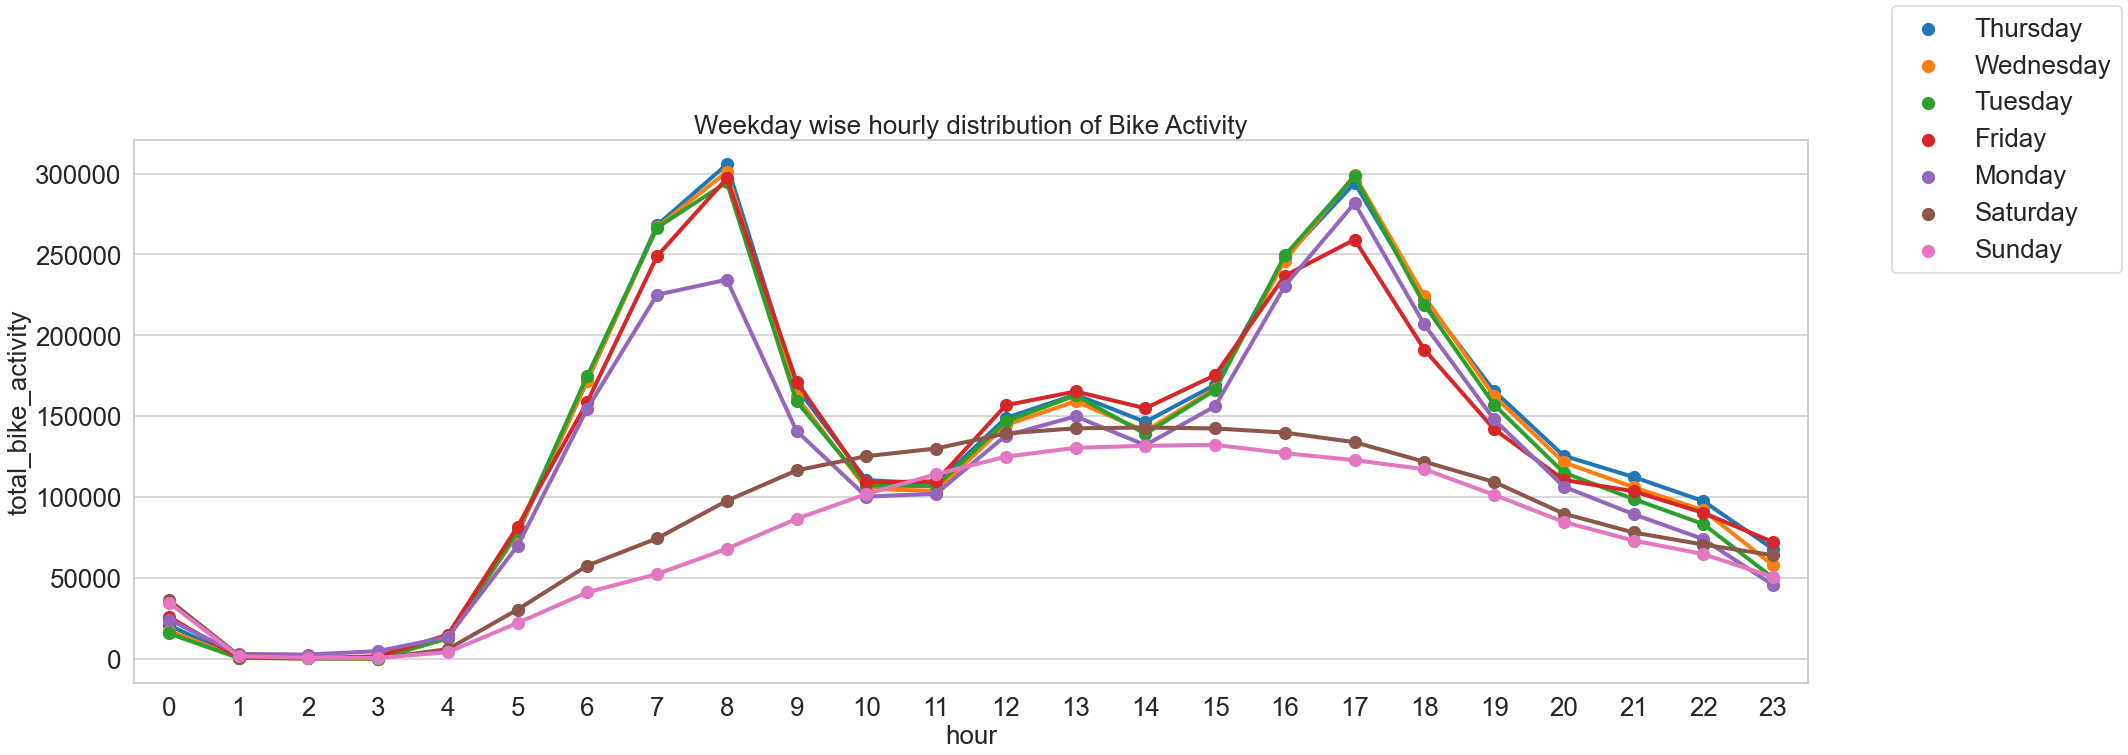

In [16]:
bike_activity_weekday_hour = merged_data.groupby(['weekday','hour'])['interactions'].sum().reset_index(name ='total_bike_activity')
bike_activity_weekday_hour = bike_activity_weekday_hour.sort_values(by='total_bike_activity',ascending=False) 
bike_activity_weekday_hour = bike_activity_weekday_hour.reset_index(drop=True)

fig,ax = plt.subplots()
sns.pointplot(data=bike_activity_weekday_hour[['hour',
                           'total_bike_activity',
                           'weekday']],
              x='hour',
              y='total_bike_activity',
              hue='weekday',
              ax=ax)
ax.set(title="Weekday wise hourly distribution of Bike Activity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


### Bike Activity on Holidays

Text(0, 0.5, 'Bike Activity')

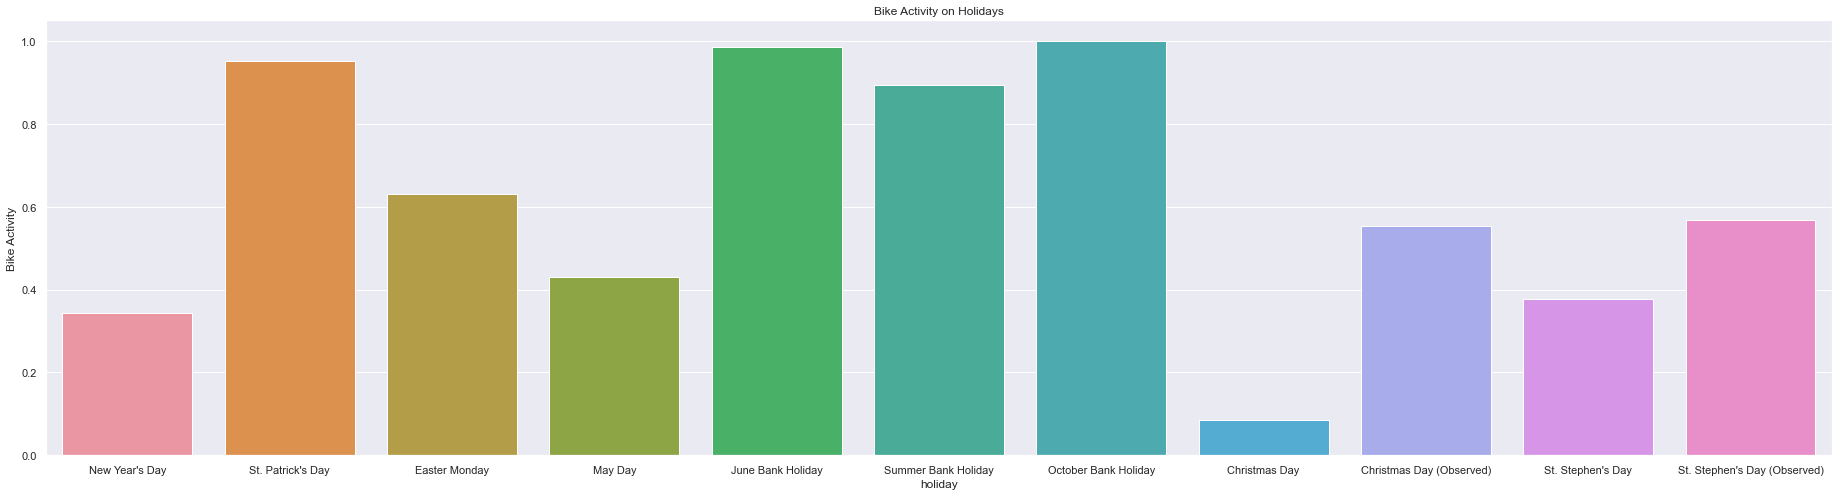

In [17]:
holiday_data = merged_data[(merged_data['year'] == 2021) & (merged_data['holiday'] != "casual_day")]
holiday_data = holiday_data.groupby(['holiday','month'])['interactions'].sum().reset_index(name ='total_bike_activity')
holiday_data = holiday_data.sort_values(by='month') 
#holiday_data = holiday_data.reset_index(drop=True)
holiday_data['total_bike_activity'] = holiday_data['total_bike_activity']/max(holiday_data['total_bike_activity'])
#plot the results
sns.set(rc={'figure.figsize':(32,8)})
ax = sns.barplot(x='holiday', y='total_bike_activity', data=holiday_data)
ax.set_title('Bike Activity on Holidays')
ax.set_ylabel('Bike Activity')

### Bike Activity Analysis According to Beaufort Wind Scale

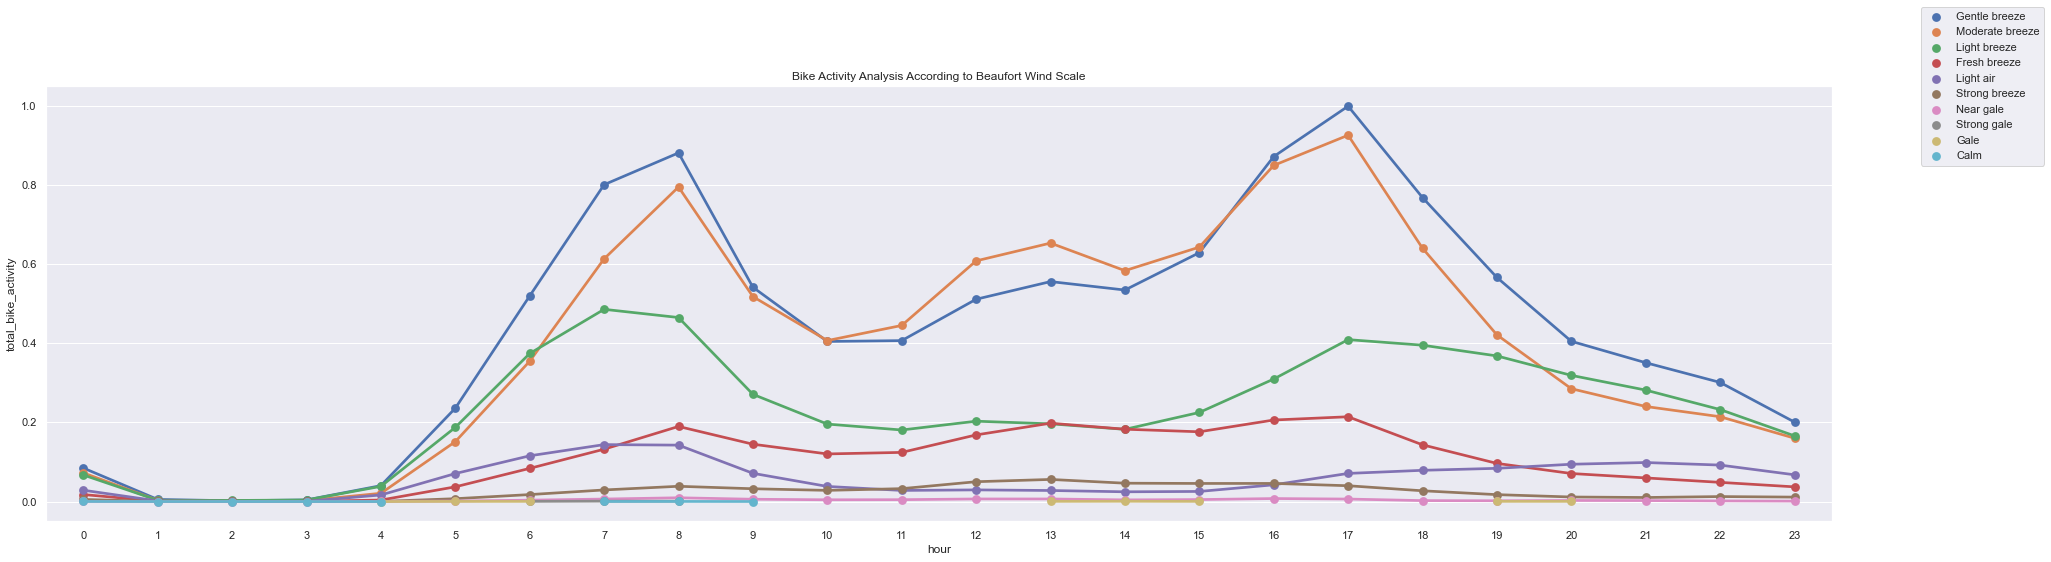

In [18]:
wind_categories_data = merged_data
wind_categories_data_weekday_hour = wind_categories_data.groupby(['wdsp_classified','hour'])['interactions'].sum().reset_index(name ='total_bike_activity')

wind_categories_data_weekday_hour['total_bike_activity'] = wind_categories_data_weekday_hour['total_bike_activity']/max(wind_categories_data_weekday_hour['total_bike_activity'])

wind_categories_data_weekday_hour = wind_categories_data_weekday_hour.sort_values(by='total_bike_activity',ascending=False) 
wind_categories_data_weekday_hour = wind_categories_data_weekday_hour.reset_index(drop=True)

fig,ax = plt.subplots()
sns.pointplot(data=wind_categories_data_weekday_hour[['hour',
                           'total_bike_activity',
                           'wdsp_classified']],
              x='hour',
              y='total_bike_activity',
              hue='wdsp_classified',
              ax=ax)
ax.set(title="Bike Activity Analysis According to Beaufort Wind Scale")
plt.legend(bbox_to_anchor=(1.05, 1), loc='center left', borderaxespad=0)


# Clustering Analysis 


In [19]:
#group data into clusters
clustering_df = merged_data[['id', 'name', 'latitude', 'longitude', 'day_type', 'classified_time', 'interactions','cluster_group']]
clustering_df = clustering_df.groupby(['id', 'name', 'latitude', 'longitude', 'cluster_group'],as_index=False)['interactions'].mean()
clustering_df  = clustering_df.set_index('id')
#clustering_df.sample(5)

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['name', 'id','latitude', 'longitude'] , columns=['cluster_group'], values='interactions')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('name')
clustering_df = clustering_df.apply(lambda x: x.fillna(x.mean()),axis=0)

clustering_df.sample(5)

#clustering algo
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
KM = KMeans(n_clusters=3) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()

locations.columns
col_list = ['11AM-3PM Saturday',
       '11AM-3PM Sunday', '11AM-3PM Weekday', '4PM-7PM Saturday',
       '4PM-7PM Sunday', '4PM-7PM Weekday', '6AM-10AM Saturday',
       '6AM-10AM Sunday', '6AM-10AM Weekday', '8PM-11PM Saturday',
       '8PM-11PM Sunday', '8PM-11PM Weekday', 'Overnight Saturday',
       'Overnight Sunday', 'Overnight Weekday']
locations['rank'] = locations[col_list].mean(axis=1)
locations = locations.sort_values(['rank'])
locations.sample(5)


cluster_group                  name  id   latitude  longitude  \
62                  KILMAINHAM GAOL  97  53.342113  -6.310015   
26                 EXCHEQUER STREET   9  53.343034  -6.263578   
50                    HERBERT PLACE  19  53.334432  -6.245575   
8              CATHAL BRUGHA STREET  24  53.352149  -6.260533   
6                   BROOKFIELD ROAD  84  53.339005  -6.300217   

cluster_group  11AM-3PM Saturday  11AM-3PM Sunday  11AM-3PM Weekday  \
62                      0.660263         0.633678          0.411653   
26                      1.136740         0.971312          1.045302   
50                      0.924711         0.791292          1.105806   
8                       0.685065         0.697031          0.793216   
6                       0.441058         0.330717          0.290421   

cluster_group  4PM-7PM Saturday  4PM-7PM Sunday  4PM-7PM Weekday  \
62                     0.499711        0.476132         0.799216   
26                     1.092146        0.978876         1.327269   
50                     0.872155        0.772546         1.609949   
8                      0.674906        0.661829         0.968036   
6                      0.412063        0.343070         0.663821   

cluster_group  6AM-10AM Saturday  6AM-10AM Sunday  6AM-10AM Weekday  \
62                      0.440083         0.310109          0.725868   
26                      0.975961         0.658937          1.176229   
50                      0.563853         0.436931          1.574118   
8                       0.517332         0.438548          0.737441   
6                       0.312636         0.213637          0.528167   

cluster_group  8PM-11PM Saturday  8PM-11PM Sunday  8PM-11PM Weekday  \
62                      0.218592         0.234556          0.300474   
26                      0.666989         0.519709          0.828080   
50                      0.587933         0.468708          0.661232   
8                       0.486626         0.488172          0.539369   
6                       0.236142         0.217149          0.268472   

cluster_group  Overnight Saturday  Overnight Sunday  Overnight Weekday  \
62                       0.045405          0.031978           0.071503   
26                       0.117738          0.099322           0.111628   
50                       0.066177          0.067405           0.100379   
8                        0.082808          0.083608           0.103628   
6                        0.048981          0.041084           0.051301   

cluster_group  Cluster      rank  
62                   0  0.390615  
26                   2  0.780416  
50                   2  0.706880  
8                    0  0.530508  
6                    1  0.293248

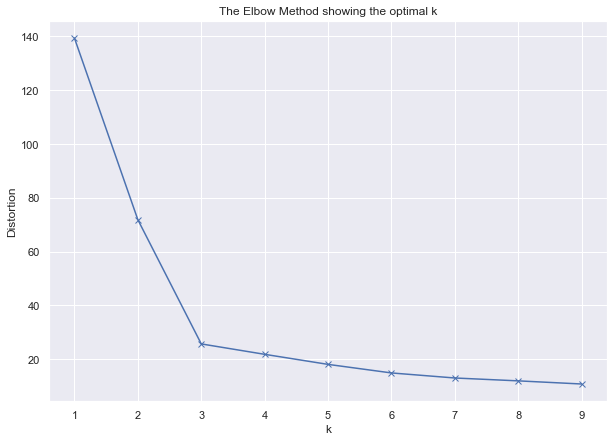

In [20]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['id', 'latitude', 'longitude'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.figsize'] = (10, 8)
colordict = {0: 'red', 1: 'blue', 2: 'green'}
dublin_map = folium.Map([53.350140, -6.266155], zoom_start=13,attr = '© OpenStreetMap contributors, © CartoDB')
for latitude, longitude, Cluster,name in zip(locations['latitude'],locations['longitude'], locations['Cluster'],locations['name']):
    folium.CircleMarker(
        [latitude, longitude],
        color = 'b',
        radius = 5,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9,
        popup=name
        ).add_to(dublin_map)
dublin_map

In [22]:
#merge clusters back into main dataset

merged_with_clusters = merged_data
cluster_output = locations[['id', 'Cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
#del merged_data
merged_with_clusters = pd.merge(merged_with_clusters, cluster_output, on = 'id', how = 'left')


In [23]:
merged_with_clusters.shape

(45150644, 31)

### Bike Activity Analysis On Weekday and Weekend 

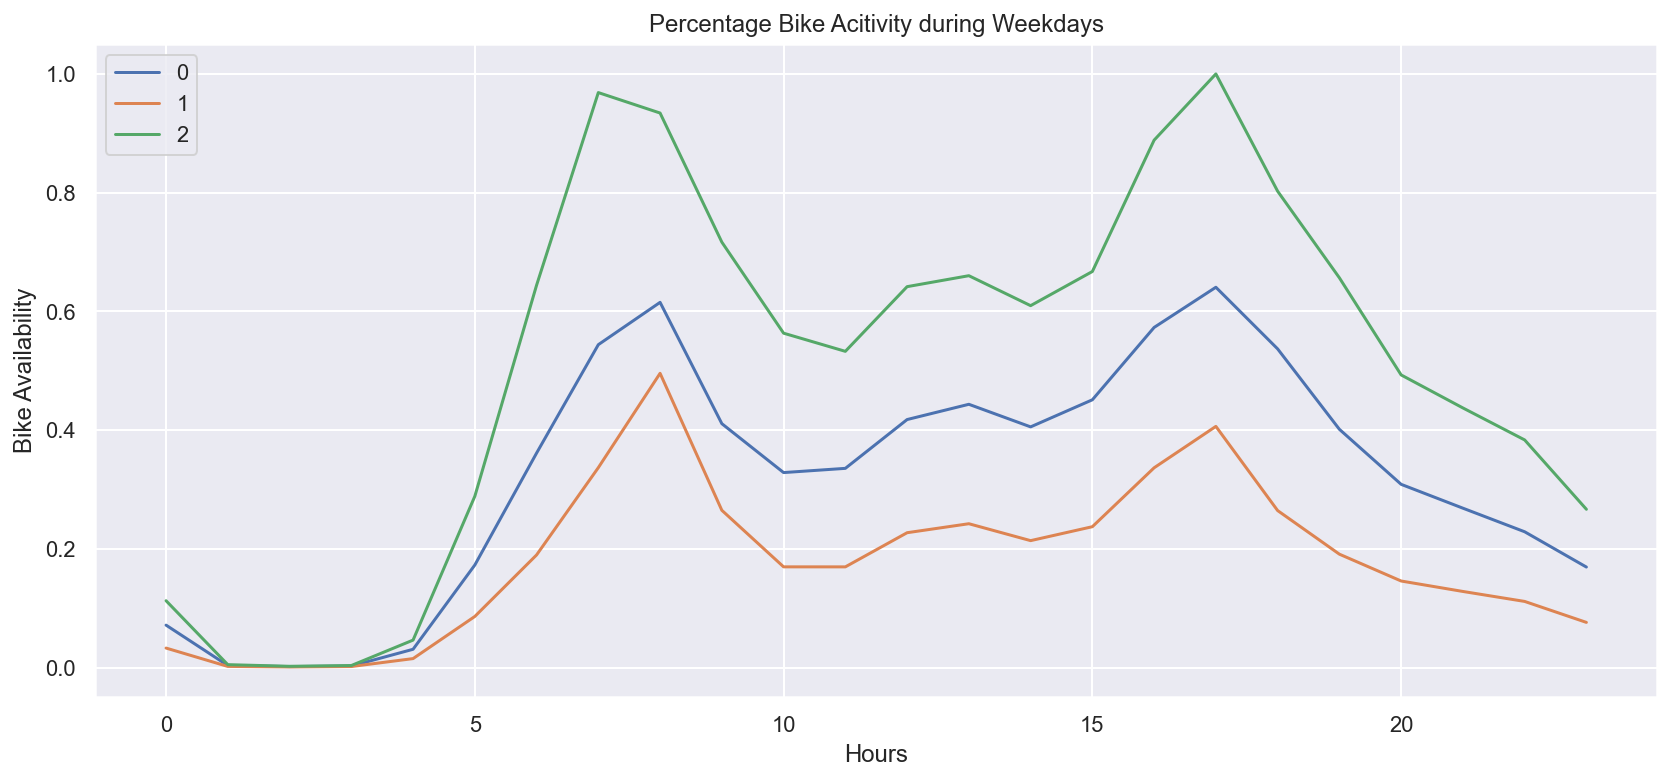

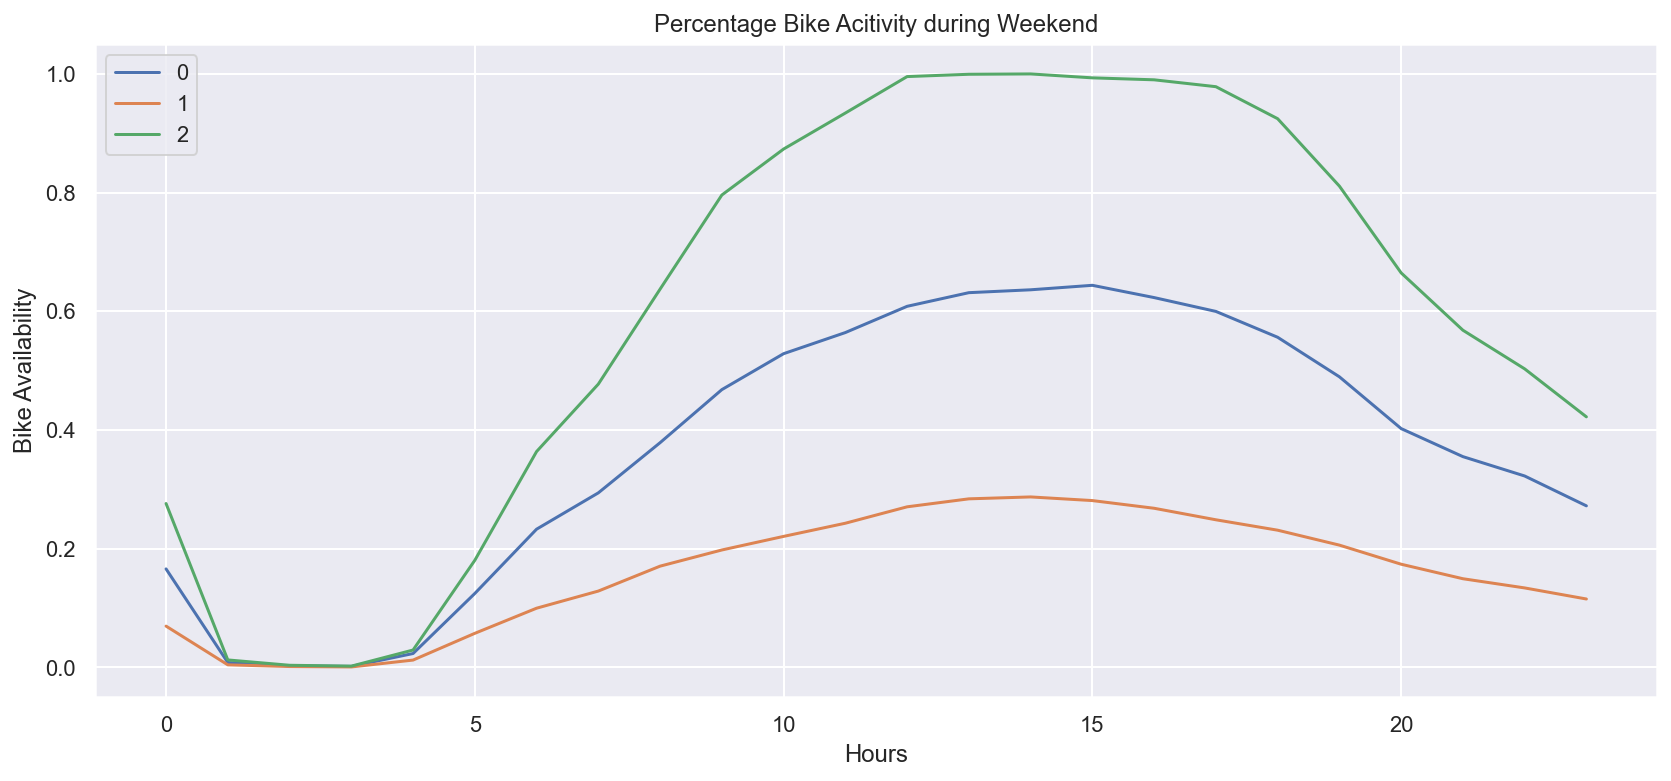

In [24]:
# # Filter weekdays
weekly_data = merged_with_clusters[(merged_with_clusters['weekday']!= "Saturday") | (merged_with_clusters['weekday']!= "Sunday")]
weekend_data = merged_with_clusters[(merged_with_clusters['weekday']== "Saturday") | (merged_with_clusters['weekday']== "Sunday")]

# Group by clusters first, then by hours, then adding all the activity values
weekly_data = weekly_data.groupby(['Cluster','hour'])['interactions'].mean()
weekend_data = weekend_data.groupby(['Cluster','hour'])['interactions'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()
weekend_data = weekend_data/weekend_data.max()

# Plot the results for weekly data
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Acitivity during Weekdays')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()

# Plot the results for weekend
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekend_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Acitivity during Weekend')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()


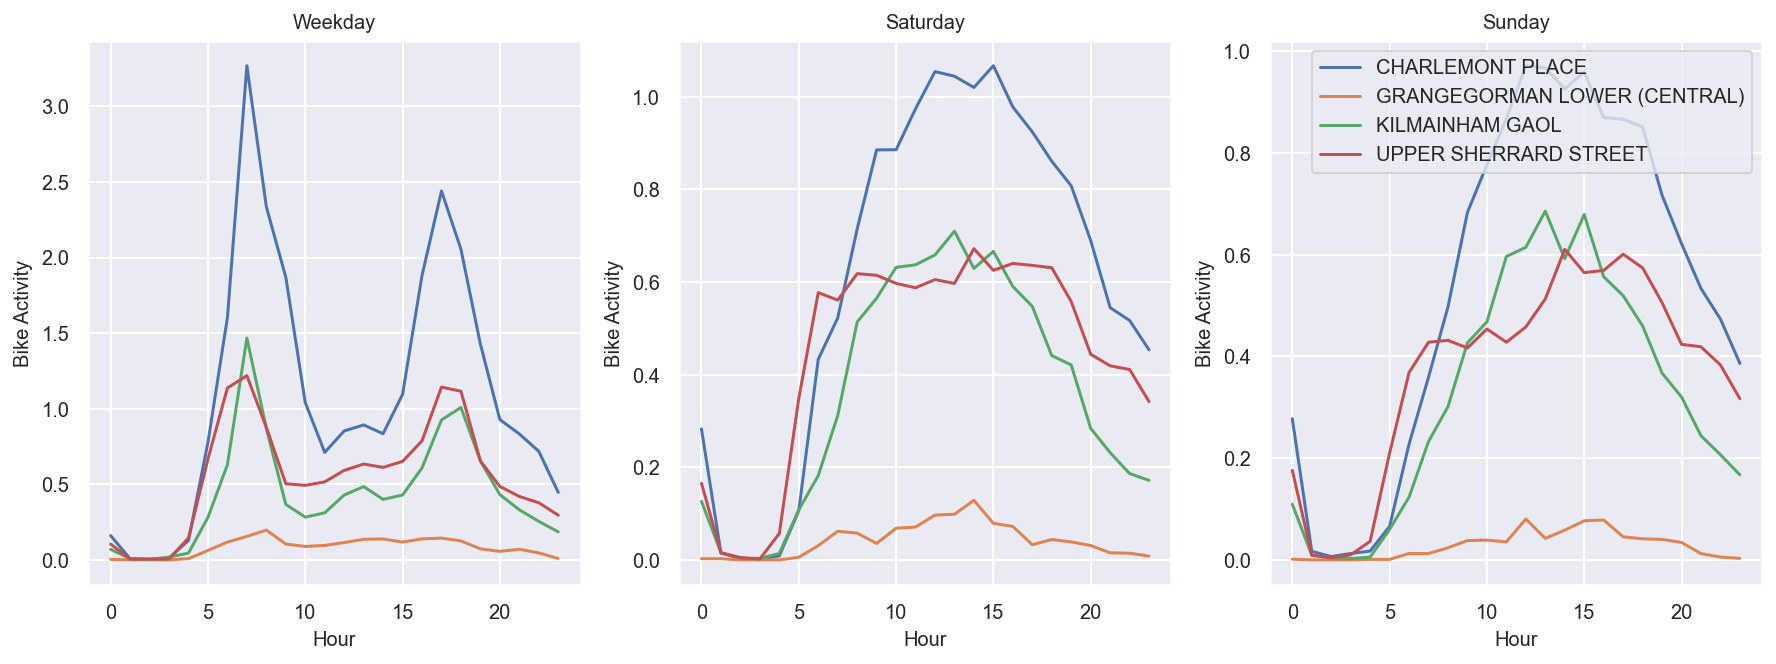

In [25]:
linechart_data = merged_with_clusters[['id','name','day_type','hour', 'interactions','Cluster']]

selected_stations = [5,44,97,104]

linechart_data = linechart_data[linechart_data['id'].isin(selected_stations)]

#Weekday
linechart_data_weekday = linechart_data[linechart_data['day_type'] == 'Weekday']
linechart_data_weekday = linechart_data_weekday.groupby(['id','name','hour'])['interactions'].mean()
#linechart_data_weekday = linechart_data_weekday['interactions']/max(linechart_data_weekday['interactions'])
linechart_data_weekday  = linechart_data_weekday.reset_index()

y1 = linechart_data_weekday['interactions'].values
x1 = linechart_data_weekday['hour'].values
labels1 = linechart_data_weekday['name'].values
colours1 = linechart_data_weekday['name'].values
df1 = pd.DataFrame(dict(x=x1, y=y1, label=labels1))
groups1 = df1.groupby('label')

#Saturday
linechart_data_saturday = linechart_data[linechart_data['day_type'] == 'Saturday']
linechart_data_saturday = linechart_data_saturday.groupby(['id','name','hour'])['interactions'].mean()
linechart_data_saturday  = linechart_data_saturday.reset_index()
y2 = linechart_data_saturday['interactions'].values
x2 = linechart_data_saturday['hour'].values
labels2 = linechart_data_saturday['name'].values
colours2 = linechart_data_saturday['name'].values
df2 = pd.DataFrame(dict(x=x2, y=y2, label=labels2))
groups2 = df2.groupby('label')

#Sunday
linechart_data_sunday = linechart_data[linechart_data['day_type'] == 'Sunday']
linechart_data_sunday = linechart_data_sunday.groupby(['id','name','hour'])['interactions'].mean()
linechart_data_sunday  = linechart_data_sunday.reset_index()
y3 = linechart_data_sunday['interactions'].values
x3 = linechart_data_sunday['hour'].values
labels3 = linechart_data_sunday['name'].values
colours3 = linechart_data_sunday['name'].values
df3 = pd.DataFrame(dict(x=x3, y=y3, label=labels3))
groups3 = df3.groupby('label')

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for name, group in groups1:
    axs[0].plot(group.x, group.y, label=name)
    axs[0].set_title('Weekday')
    axs[0].set_xlabel('Hour')
    axs[0].set_ylabel('Bike Activity')
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)
    
for name, group in groups2:
    axs[1].plot(group.x, group.y, label=name)
    axs[1].set_title('Saturday')
    axs[1].set_xlabel('Hour')
    axs[1].set_ylabel('Bike Activity')
    
    
for name, group in groups3:
    axs[2].plot(group.x, group.y, label=name)
    axs[2].set_title('Sunday')
    axs[2].set_xlabel('Hour')
    axs[2].set_ylabel('Bike Activity')
    axs[2].legend()

plt.show()

In [26]:
s = merged_data.groupby(['id','name'])['interactions'].sum().reset_index(name ='total_bike_activity')


In [27]:
s

id                               name  total_bike_activity
0      1                      CLARENDON ROW             162851.0
1      2                 BLESSINGTON STREET             167750.0
2      3                      BOLTON STREET             187948.0
3      4                       GREEK STREET             140924.0
4      5                   CHARLEMONT PLACE             395503.0
5      6                 CHRISTCHURCH PLACE             162382.0
6      7                        HIGH STREET             146859.0
7      8                  CUSTOM HOUSE QUAY             243178.0
8      9                   EXCHEQUER STREET             337410.0
9     10                        DAME STREET             215252.0
10    11                  EARLSFORT TERRACE             142579.0
11    12                      ECCLES STREET             157645.0
12    13            FITZWILLIAM SQUARE WEST             123228.0
13    15                   HARDWICKE STREET              97356.0
14    16                       GEORGES QUAY             104157.0
15    17                        GOLDEN LANE             130800.0
16    18                    GRANTHAM STREET             264411.0
17    19                      HERBERT PLACE             337640.0
18    21              LEINSTER STREET SOUTH             220572.0
19    22                    TOWNSEND STREET             213895.0
20    23                       CUSTOM HOUSE             248117.0
21    24               CATHAL BRUGHA STREET             222471.0
22    25                MERRION SQUARE EAST             143990.0
23    26                MERRION SQUARE WEST             152222.0
24    27                  MOLESWORTH STREET             165352.0
25    28               MOUNTJOY SQUARE WEST             305366.0
26    29                  ORMOND QUAY UPPER             236588.0
27    30               PARNELL SQUARE NORTH             106302.0
28    31                     PARNELL STREET             282930.0
29    32                      PEARSE STREET             269562.0
30    33  PRINCES STREET / O'CONNELL STREET             327279.0
31    34                 PORTOBELLO HARBOUR             397641.0
32    36           ST. STEPHEN'S GREEN EAST             190698.0
33    37          ST. STEPHEN'S GREEN SOUTH             130035.0
34    38                      TALBOT STREET             284401.0
35    39                     WILTON TERRACE             236589.0
36    40                      JERVIS STREET             228268.0
37    41                   HARCOURT TERRACE             126209.0
38    42                   SMITHFIELD NORTH             252996.0
39    43                    PORTOBELLO ROAD             270878.0
40    44              UPPER SHERRARD STREET             227178.0
41    45                     DEVERELL PLACE             129764.0
42    47                     HERBERT STREET             136136.0
43    48                        EXCISE WALK             244425.0
44    49                       GUILD STREET             260466.0
45    50                       GEORGES LANE             138421.0
46    51                   YORK STREET WEST             159925.0
47    52                   YORK STREET EAST             236759.0
48    53                       NEWMAN HOUSE             122379.0
49    54                     CLONMEL STREET             131955.0
50    55                       HATCH STREET             114899.0
51    56                 MOUNT STREET LOWER             294370.0
52    57                     GRATTAN STREET             111518.0
53    58                  SIR PATRICK DUN'S             291802.0
54    59               DENMARK STREET GREAT             112421.0
55    61                    HARDWICKE PLACE             149751.0
56    62                        LIME STREET             169916.0
57    63                      FENIAN STREET             165985.0
58    64                    SANDWITH STREET             201594.0
59    65                  CONVENTION CENTRE             154330.0
60    66                   NEW CENTRAL BA